In [1]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
import os
import tifffile
import pandas as pd
from scipy.optimize import minimize_scalar
from sklearn.preprocessing import minmax_scale

import pandas as pd
import torch
import torch.nn.functional as F

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# 定义正态分布函数
def modelFun(x, p1, p2, p3):
    return p1*np.exp(-p2*(x-p3)**2)
    # return 1/(sigma * np.sqrt(2*np.pi)) * np.exp(-((x - mu)**2)/(2 * sigma**2))

def PixSpecMapping(pix):
    spec = 0.02215*pix**2+3.077*pix+591.6
    return spec

def SpecPixMapping(spec):
    pix = -0.0009465*spec**2+1.455*spec-529.4
    return pix

In [ ]:
###### simu data #########

folder_path = '/data/shahao/spms_track/simu_data/test/'
file_extension = '.tiff'
file_names = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(file_extension)]

imgdim = [40,7]          # simulation image size (x,y) in pixel
# read csv file
df = pd.read_csv(folder_path+'/labels.csv')
# Convert DataFrame to a dictionary
data_dict = df.to_dict('list')
data_dict['img'] = np.zeros((imgdim[1],imgdim[0],len(data_dict['photons'])))
data_dict['img_centroid'] = np.zeros((1,len(data_dict['photons'])))

for i,file_name in enumerate(file_names):
    imgs = tifffile.imread(file_name)
    start = file_name.find("centroid") + len("centroid")
    end = file_name.find(".tiff")
    label_centroid = float(file_name[start:end].replace('_','.'))

    N_per_S = imgs.shape[0]
    data_dict['img'][:,:,i*N_per_S:(i+1)*N_per_S] = imgs.transpose(1,2,0)
    data_dict['img_centroid'][0,i*N_per_S:(i+1)*N_per_S] = label_centroid


lamb_x = PixSpecMapping(np.arange(-20,20,1)-0.888066)  # 40/2 = 20-> 591.6
centroids = np.unique(np.array(data_dict['centroid']))
fit_centroid = {}
fit_centroid['photons'], fit_centroid['background'], fit_centroid['diffusivity'] = {}, {}, {}
for centroid in tqdm(centroids):
    idx = np.where((np.array(data_dict['img_centroid'])[0] == centroid))
                # & (np.array(data_dict['photons']) == 110)
                # & (np.array(data_dict['background']) == 500)
                # & (np.array(data_dict['diffusivity']) == 0)) # filter
                
    spec = np.mean(data_dict['img'][:,:,idx], axis=0)
    spec_norm = minmax_scale(spec.squeeze(1),axis=0)
    fitcen_arr = np.zeros(spec_norm.shape[-1])

    for i in range(spec_norm.shape[-1]):
        # startingVals = [1,0.001,centroid]
        startingVals = [1,0.001,610]
        popt, pcov = curve_fit(modelFun, lamb_x, spec_norm[:,i], p0=startingVals, maxfev=10000)
        # print(lamb_x)
        res = minimize_scalar(lambda x: -modelFun(x, *popt), bounds=(560,640), method='bounded')
        fitted_centroid = round(res.x, 4)

        fitcen_arr[i] = fitted_centroid

    fit_centroid[centroid] = fitcen_arr
    fit_centroid['photons'][centroid] = np.array(data_dict['photons'])[idx]
    fit_centroid['background'][centroid] = np.array(data_dict['background'])[idx]
    fit_centroid['diffusivity'][centroid] = np.array(data_dict['diffusivity'])[idx]

In [29]:
test_cen = 601
errors = 0

for centroid in list(fit_centroid.keys())[3:]:
    fit_cen = fit_centroid[centroid]
    centroids = np.repeat(centroid, fit_cen.shape, axis=0)
    errors += np.sqrt(np.array(((fit_cen - centroids)**2)).mean())

erros = errors/len(list(fit_centroid.keys())[3:])

print(errors)


53.73839114832137


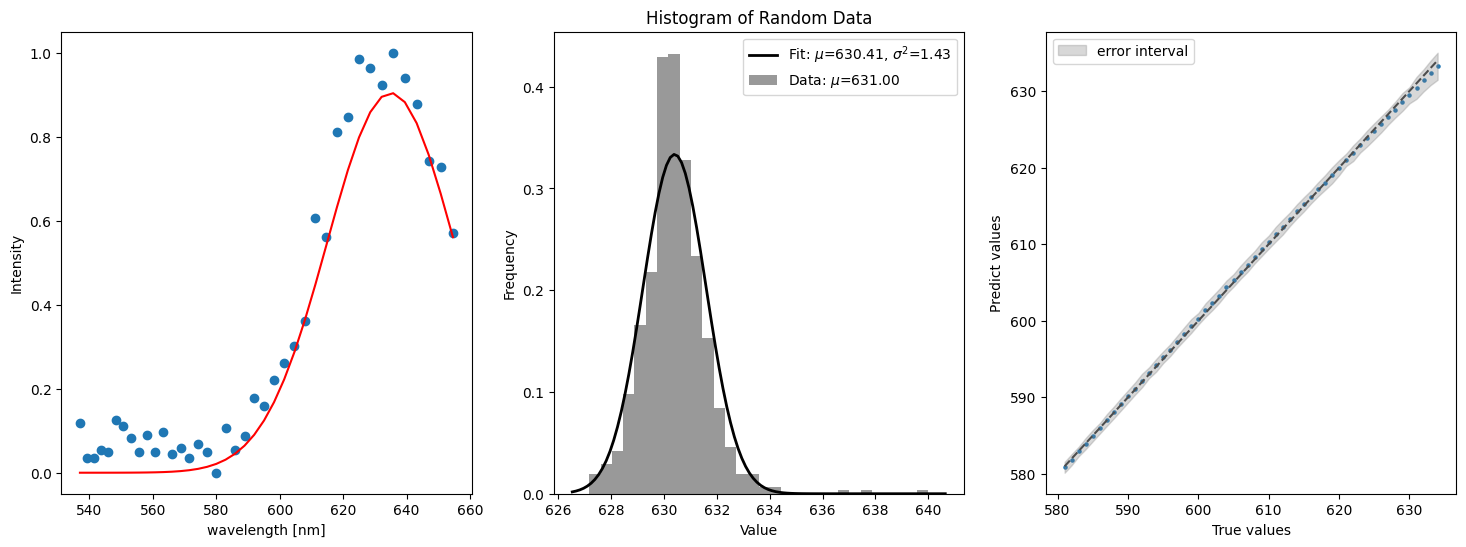

In [36]:

# 绘制平均强度曲线
fig = plt.figure(1,figsize=(18,6))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.scatter(lamb_x, spec_norm[:,0])
ax1.plot(lamb_x, modelFun(lamb_x, *popt),'r', label='fit')
ax1.set_xlabel('wavelength [nm]')
ax1.set_ylabel('Intensity')

from scipy.stats import norm

test_cen = 631

fitcen_arr = fit_centroid[test_cen]
ax2.hist(fitcen_arr, bins=30, density=True, alpha=0.8, color='gray')
mu, std = norm.fit(fitcen_arr)
xmin, xmax = ax2.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax2.plot(x, p, 'k', linewidth=2)
ax2.legend(('Fit: $\mu$={:.2f}, $\sigma^2$={:.2f}'.format(mu, std**2), 
            'Data: $\mu$={:.2f}'.format(test_cen)), fontsize=10)
ax2.set_xlabel('Value')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of Random Data')

true_values = np.array(list(fit_centroid.keys())[3:])
predict_values = np.array(list(fit_centroid.values())[3:])

#########################################
mu,var,errs = [],[],[]
for i,predict_value in enumerate(predict_values):
    m, s = norm.fit(predict_value.astype(float))
    mu.append(m)
    var.append(s**2)

    # centroids = np.repeat(true_values[i], predict_value.shape, axis=0)
    # rmse = np.sqrt(np.array(((predict_value - centroids)**2)).mean())

    # errs.append(rmse)


mu = np.round(np.array(mu),decimals=3)
var = np.array(var)

ax3.plot(true_values, true_values, 'r', ls="--", c=".3")
ax3.scatter(true_values, mu, s=5)
ax3.fill_between(true_values, mu-var, mu+var, color='gray', alpha=0.3, label='error interval')

ax3.set_xlabel("True values")
ax3.set_ylabel("Predict values")
ax3.legend()

plt.show()



In [2]:

def plot_hist(data, label, ax, hist_title):
    ax.hist(data, bins=30, density=True, alpha=0.8, color='gray')
    mu, std = norm.fit(data)
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    ax.plot(x, p, 'k', linewidth=2)
    ax.legend(('Fit: $\mu$={:.2f}, $\sigma^2$={:.2f}'.format(mu, std**2), 
                'Data: $\mu$={:.2f}'.format(label)), fontsize=10)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.set_title(hist_title)



In [ ]:

fig = plt.figure(1,figsize=(12,12))
test_cen = 611
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

photons = 60
diffusivity = 0
idx = np.where(fit_centroid['diffusivity'][test_cen] == diffusivity)
fitcen_arr = fit_centroid[test_cen][idx]
plot_hist(fitcen_arr, test_cen, ax1, f'diffusivity = {diffusivity}')

photons = 110
diffusivity = 0.4
idx = np.where(fit_centroid['diffusivity'][test_cen] == diffusivity)
fitcen_arr = fit_centroid[test_cen][idx]
plot_hist(fitcen_arr, test_cen, ax2, f'diffusivity = {diffusivity}')


background = 500
photons = 110
idx = np.where((fit_centroid['photons'][test_cen] == photons)
               & (fit_centroid['background'][test_cen] == background)
               & (fit_centroid['diffusivity'][test_cen] == 0))
fitcen_arr = fit_centroid[test_cen][idx]
plot_hist(fitcen_arr, test_cen, ax3, f'background = {background}, photons = {photons}, diffusivity = {0}')

background = 1100
photons = 60
idx = np.where((fit_centroid['photons'][test_cen] == photons)
               & (fit_centroid['background'][test_cen] == background)
               & (fit_centroid['diffusivity'][test_cen] == 0.4))
fitcen_arr = fit_centroid[test_cen][idx]
plot_hist(fitcen_arr, test_cen, ax4, f'background = {background}, photons = {photons}, diffusivity = {0.4}')



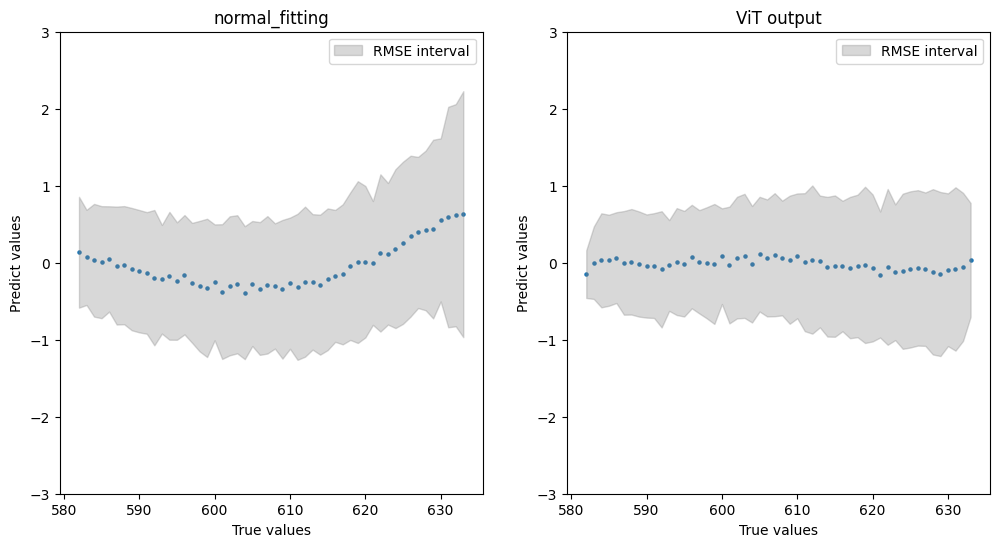

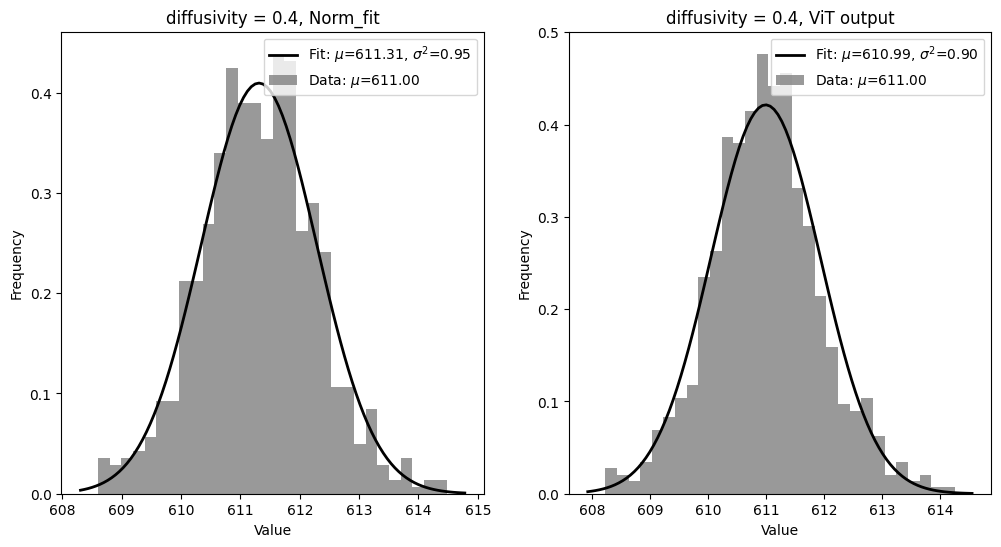

In [37]:


# 读取csv文件
df = pd.read_csv('/data/shahao/spms_track/simu_data/test/outputs/ViT-iRPE/\
ViT-iRPE-epoch=110-val_loss=0.34.ckpt/test_outputs.csv')

# 将DataFrame转换为字典
data_dict = df.to_dict()

ViT_Preds = np.array(list(data_dict['preds'].values()))
labels =  np.array(list(data_dict['gt_centroids'].values()))
ViT_diff = np.array(list(data_dict['diffusivity'].values()))
ViT_photons =  np.array(list(data_dict['photons'].values()))
ViT_back =  np.array(list(data_dict['background'].values()))

ViT_mu, ViT_var = [],[]

true_values_ = true_values[1:-1]
mu_ = mu[1:-1]
var_ = var[1:-1]

test_cen = 601
errors = []

for label in true_values_:
    idx = np.where(labels == label)
    ViT_Pred = ViT_Preds[idx]

    # centroids = np.repeat(label, ViT_Pred.shape, axis=0)
    # rmse = np.sqrt(np.array(((ViT_Pred - centroids)**2)).mean())

    # errors.append(rmse)

    m, s = norm.fit(ViT_Pred.astype(float))
    ViT_mu.append(m)
    ViT_var.append(s**2)

ViT_mu = np.round(np.array(ViT_mu),decimals=3)
ViT_var = np.array(ViT_var)

fig = plt.figure(3,figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# ax1.plot(true_values, true_values, 'r', ls="--", c=".3")
ax1.scatter(true_values_, true_values_-mu_, s=5)
ax1.fill_between(true_values_, true_values_-mu_-var_, true_values_-mu_+var_, color='gray', alpha=0.3, label='RMSE interval')
ax1.set_xlabel("True values")
ax1.set_ylabel("Predict values")
ax1.set_ylim(-3,3)
ax1.set_title("normal_fitting")
ax1.legend()


# ax2.plot(true_values, true_values, 'r', ls="--", c=".3")
ax2.scatter(true_values_, true_values_-ViT_mu, s=5)
# ax2.fill_between(true_values_, true_values_-ViT_mu-ViT_var, true_values_-ViT_mu+ViT_var, color='gray', alpha=0.3, label='error interval')
ax2.fill_between(true_values_, true_values_-ViT_mu-ViT_var, true_values_-ViT_mu+ViT_var, color='gray', alpha=0.3, label='RMSE interval')
ax2.set_xlabel("True values")
ax2.set_ylabel("Predict values")
ax2.set_ylim(-3,3)
ax2.set_title("ViT output")
ax2.legend()

plt.show()

fig = plt.figure(4,figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

test_cen = 611
photons = 110
background = 500
diffusivity = 0.4
# idx = np.where(fit_centroid['diffusivity'][test_cen] == diffusivity)
fitcen_arr = fit_centroid[test_cen]
plot_hist(fitcen_arr, test_cen, ax1, f'diffusivity = {diffusivity}, Norm_fit')

idx = np.where(labels == test_cen)
# idx = np.intersect1d(np.where(ViT_diff == diffusivity), np.where(labels == test_cen))
fitcen_arr = ViT_Preds[idx]
plot_hist(fitcen_arr, test_cen, ax2, f'diffusivity = {diffusivity}, ViT output')

plt.show()

Text(0.5, 1.0, 'Histogram of Random Data')

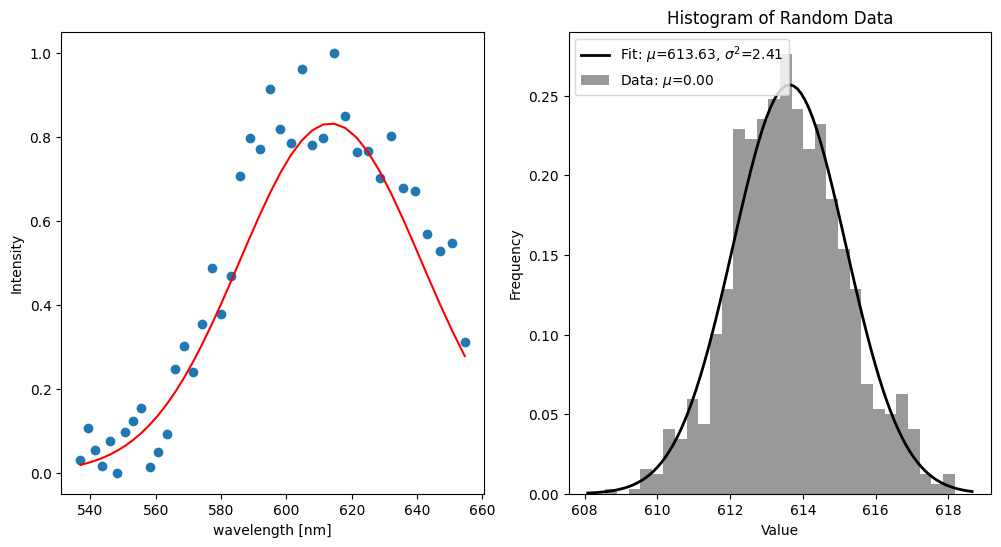

In [9]:
###### experiments data #########
folder_path = '/data/shahao/spms_track/experiments/SiSNR/'
# file_extension = '.tiff'
# file_names = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(file_extension)]
file_name = folder_path + 'SiSNR.tiff'
data_dict = {}

imgdim = [40,7]          # simulation image size (x,y) in pixel
imgs = tifffile.imread(file_name)
N_per_S = imgs.shape[0]
data_dict['img'] = imgs.transpose(1,2,0)

lamb_x = PixSpecMapping(np.arange(-20,20,1)-0.888066)  # 40/2 = 20-> 591.6
spec = np.mean(data_dict['img'], axis=0)
spec_norm = minmax_scale(spec,axis=0)

fitcen_arr = np.zeros(spec_norm.shape[-1])

for i in range(spec_norm.shape[-1]):
    # startingVals = [1,0.001,centroid]  

    startingVals = [1,0.001,620]
    popt, pcov = curve_fit(modelFun, lamb_x, spec_norm[:,i], p0=startingVals, maxfev=10000)
    res = minimize_scalar(lambda x: -modelFun(x, *popt), bounds=(580,680), method='bounded')
    fitted_centroid = round(res.x, 4)

    fitcen_arr[i] = fitted_centroid

data_dict['centroid'] = fitcen_arr

# 绘制平均强度曲线
fig = plt.figure(1,figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.scatter(lamb_x, spec_norm[:,0])
ax1.plot(lamb_x, modelFun(lamb_x, *popt),'r', label='fit')
ax1.set_xlabel('wavelength [nm]')
ax1.set_ylabel('Intensity')

from scipy.stats import norm

fitcen_arr = data_dict['centroid']
ax2.hist(fitcen_arr, bins=30, density=True, alpha=0.8, color='gray')
mu, std = norm.fit(fitcen_arr)
xmin, xmax = ax2.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax2.plot(x, p, 'k', linewidth=2)
ax2.legend(('Fit: $\mu$={:.2f}, $\sigma^2$={:.2f}'.format(mu, std**2), 
            'Data: $\mu$={:.2f}'.format(0)), fontsize=10)
ax2.set_xlabel('Value')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of Random Data')


Text(0.5, 1.0, 'Histogram of ViT output')

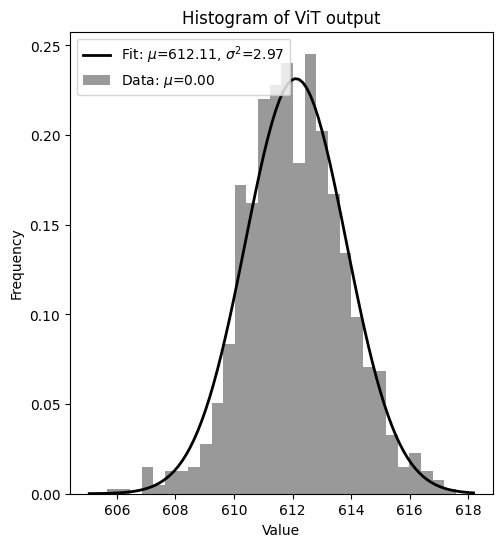

In [10]:

################ ViT output ###################
folder_path = '/data/shahao/spms_track/experiments/SiSNR/outputs/\
ViT_skip_aug-iRPE/ViT_skip_aug-iRPE-epoch=108-val_loss=0.36.ckpt/'
file_name = folder_path + 'SiSNR_outputs.csv'

# 读取csv文件
df = pd.read_csv(file_name)

# 将DataFrame转换为字典
data_dict = df.to_dict()

ViT_Preds = np.array(list(data_dict['preds'].values()))
m, s = norm.fit(ViT_Preds.astype(float))
ViT_mu, ViT_var = m,s**2

ViT_mu = np.round(np.array(ViT_mu),decimals=3)
ViT_var = np.array(ViT_var)

fig = plt.figure(3,figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)

ax1.hist(ViT_Preds, bins=30, density=True, alpha=0.8, color='gray')
mu, std = norm.fit(ViT_Preds)
xmin, xmax = ax1.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax1.plot(x, p, 'k', linewidth=2)
ax1.legend(('Fit: $\mu$={:.2f}, $\sigma^2$={:.2f}'.format(mu, std**2), 
            'Data: $\mu$={:.2f}'.format(0)), fontsize=10)
ax1.set_xlabel('Value')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of ViT output')

